# Find Cars from Aerial Images Using YOLO-NAS 

![Image](https://miro.medium.com/v2/resize:fit:1358/0*Y9p1AJaf1euhDSwG)


# 1. About YOLO-NAS


- **YOLO-NAS Overview:** YOLO-NAS (You Only Look Once - Neural Architecture Search) is an advanced variant of the YOLO object detection algorithm.

- **Automated Architecture Design:** YOLO-NAS incorporates neural architecture search to automatically design optimal network architectures for object detection tasks.

- **Efficiency and Accuracy:** It combines the speed and efficiency of YOLO with automated architecture tuning, potentially enhancing detection accuracy and efficiency.

- **Benefits:** YOLO-NAS reduces manual effort in network design, adapting architectures to specific datasets and tasks.

- **Applications:** YOLO-NAS is applicable to various object detection scenarios, leveraging automated architecture selection for improved performance.

- **Challenges:** Computational cost and search space design are considerations in the effectiveness of neural architecture search.

- **Advancement:** YOLO-NAS represents a step towards more efficient and automated object detection using state-of-the-art neural architecture search techniques.


In [1]:
!pip install super_gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.8/242.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 77.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━

# 2. Import

In [2]:
import os

import requests
import torch
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2023-08-20 15:24:54] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-08-20 15:24:57] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-08-20 15:25:10] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-08-20 15:25:10] WARNING - export.py - Failed to import pytorch_quantization
[2023-08-20 15:25:10] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-08-20 15:25:10] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-08-20 15:25:10] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-08-20 15:25:10] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx required but not found
[2023-08-20 15:25:10] WARNING - env_sanity_check.py - Failed to verify installed packages: hydra-core required but not found
[2023-08-20 15:25:10] WARNING - env_sanity_check.py - Failed to verify installed packages: omegaconf required but not found
[2023-08-20 15:25:10] WARN

# 3. Lets setup the Config

This class will store variables that will be used throughout the notebook

In [3]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'cars-from-above' #specify the experiment name

    #dataset params
    DATA_DIR = '../input/aerial-view-car-detection-for-yolov5/mydata/mydata' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'images/train' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'labels/train' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'images/test' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'labels/test' #child dir of DATA_DIR where validation labels are
    TEST_IMAGES_DIR = 'images/test'  # child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'labels/test'  # child dir of DATA_DIR where test labels are
    CLASSES = ['car'] #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco
    

# 3.The Trainer

In [4]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

# 4. Datasets and Dataloaders


In [5]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2023-08-20 15:25:10] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 280/280 [00:02<00:00, 102.48it/s]
[2023-08-20 15:25:13] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 19/19 [00:00<00:00, 161.65it/s]
[2023-08-20 15:25:14] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


## 4.1. Images after augmentations

Indexing dataset annotations: 100%|██████████| 19/19 [00:00<00:00, 813.18it/s]


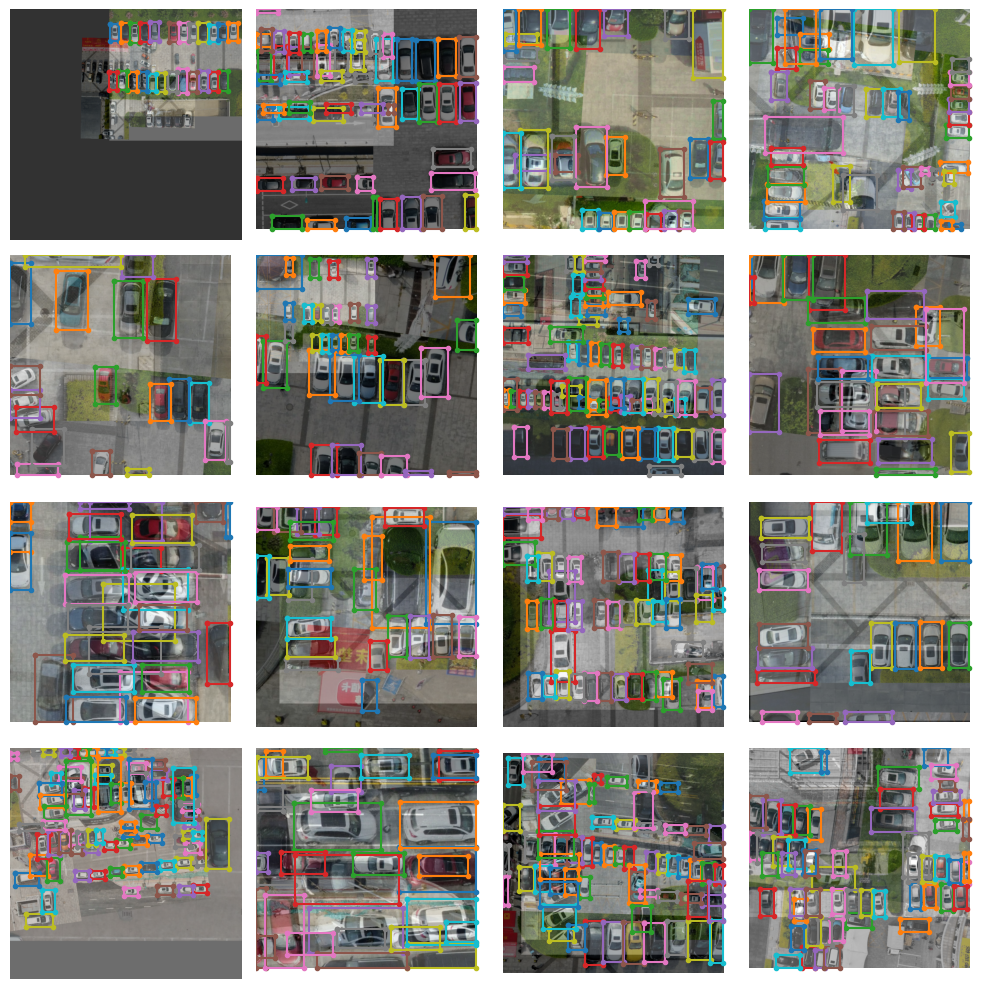

In [6]:
train_data.dataset.plot()

# 5. Instantiate the model

> Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

> Note, I'm using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [7]:
model = models.get(config.MODEL_NAME, 
                   num_classes=config.NUM_CLASSES, 
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2023-08-20 15:25:20] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
[2023-08-20 15:25:22] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


# 6.Define metrics and training parameters

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

> You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. 
> If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`. 

In [8]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 7.Train the model


✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### Now, its time to train a model 

> Training a model using a SuperGradients is done using the `trainer`.

> It's as easy as..

In [9]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

The console stream is now moved to checkpoints/cars-from-above/console_Aug20_15_25_27.txt


[2023-08-20 15:25:28] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-08-20 15:25:35] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 280        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         17         (len(train_loader))
    - Gradient updates per epoch:   17         (len(train_loader) / batch_accumulate)

[2023-08-20 15:25:35] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validating: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]
[2023-08-20 15:26:23] INFO - base_sg_logger.py - C

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.4065
│   ├── Ppyoloeloss/loss_iou = 0.2363
│   ├── Ppyoloeloss/loss_dfl = 1.1246
│   └── Ppyoloeloss/loss = 3.5595
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.6344
    ├── Ppyoloeloss/loss_iou = 0.1612
    ├── Ppyoloeloss/loss_dfl = 0.9813
    ├── Ppyoloeloss/loss = 3.5282
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.3086
    └── F1@0.50 = 0.0



Validating epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]
[2023-08-20 15:27:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cars-from-above/ckpt_best.pth
[2023-08-20 15:27:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9473577737808228


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1669
│   │   ├── Epoch N-1      = 2.4065 (↘ -1.2397)
│   │   └── Best until now = 2.4065 (↘ -1.2397)
│   ├── Ppyoloeloss/loss_iou = 0.1913
│   │   ├── Epoch N-1      = 0.2363 (↘ -0.045)
│   │   └── Best until now = 0.2363 (↘ -0.045)
│   ├── Ppyoloeloss/loss_dfl = 0.9444
│   │   ├── Epoch N-1      = 1.1246 (↘ -0.1802)
│   │   └── Best until now = 1.1246 (↘ -0.1802)
│   └── Ppyoloeloss/loss = 2.1172
│       ├── Epoch N-1      = 3.5595 (↘ -1.4424)
│       └── Best until now = 3.5595 (↘ -1.4424)
└── Validation
    ├── Ppyoloeloss/loss_cls = 15.637
    │   ├── Epoch N-1      = 2.6344 (↗ 13.0026)
    │   └── Best until now = 2.6344 (↗ 13.0026)
    ├── Ppyoloeloss/loss_iou = 0.1259
    │   ├── Epoch N-1      = 0.1612 (↘ -0.0354)
    │   └── Best until now = 0.1612 (↘ -0.0354)
    ├── Ppyoloeloss/loss_dfl = 0.774
    │   ├── Epoch N-1      = 0.9813 (↘ -0.2074)
    │   └── Best until now = 0.9813 (↘ -0.2074)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6975
│   │   ├── Epoch N-1      = 1.1669 (↘ -0.4693)
│   │   └── Best until now = 1.1669 (↘ -0.4693)
│   ├── Ppyoloeloss/loss_iou = 0.1656
│   │   ├── Epoch N-1      = 0.1913 (↘ -0.0256)
│   │   └── Best until now = 0.1913 (↘ -0.0256)
│   ├── Ppyoloeloss/loss_dfl = 0.8459
│   │   ├── Epoch N-1      = 0.9444 (↘ -0.0984)
│   │   └── Best until now = 0.9444 (↘ -0.0984)
│   └── Ppyoloeloss/loss = 1.5346
│       ├── Epoch N-1      = 2.1172 (↘ -0.5825)
│       └── Best until now = 2.1172 (↘ -0.5825)
└── Validation
    ├── Ppyoloeloss/loss_cls = 11.987
    │   ├── Epoch N-1      = 15.637 (↘ -3.65)
    │   └── Best until now = 2.6344 (↗ 9.3526)
    ├── Ppyoloeloss/loss_iou = 0.1192
    │   ├── Epoch N-1      = 0.1259 (↘ -0.0067)
    │   └── Best until now = 0.1259 (↘ -0.0067)
    ├── Ppyoloeloss/loss_dfl = 0.7462
    │   ├── Epoch N-1      = 0.774  (↘ -0.0278)
    │   └── Best until now = 0.774  (↘ -0.0278)
    ├── Ppyoloeloss/loss 

Validating epoch 3: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]
[2023-08-20 15:29:05] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cars-from-above/ckpt_best.pth
[2023-08-20 15:29:05] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9624465107917786


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.663
│   │   ├── Epoch N-1      = 0.6975 (↘ -0.0346)
│   │   └── Best until now = 0.6975 (↘ -0.0346)
│   ├── Ppyoloeloss/loss_iou = 0.1532
│   │   ├── Epoch N-1      = 0.1656 (↘ -0.0124)
│   │   └── Best until now = 0.1656 (↘ -0.0124)
│   ├── Ppyoloeloss/loss_dfl = 0.8017
│   │   ├── Epoch N-1      = 0.8459 (↘ -0.0443)
│   │   └── Best until now = 0.8459 (↘ -0.0443)
│   └── Ppyoloeloss/loss = 1.4469
│       ├── Epoch N-1      = 1.5346 (↘ -0.0877)
│       └── Best until now = 1.5346 (↘ -0.0877)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3766
    │   ├── Epoch N-1      = 11.987 (↘ -10.6104)
    │   └── Best until now = 2.6344 (↘ -1.2578)
    ├── Ppyoloeloss/loss_iou = 0.1168
    │   ├── Epoch N-1      = 0.1192 (↘ -0.0024)
    │   └── Best until now = 0.1192 (↘ -0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.7255
    │   ├── Epoch N-1      = 0.7462 (↘ -0.0207)
    │   └── Best until now = 0.7462 (↘ -0.0207)
    ├── Ppyoloeloss/lo

Validating epoch 4: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
[2023-08-20 15:30:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cars-from-above/ckpt_best.pth
[2023-08-20 15:30:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9798011183738708


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.644
│   │   ├── Epoch N-1      = 0.663  (↘ -0.019)
│   │   └── Best until now = 0.663  (↘ -0.019)
│   ├── Ppyoloeloss/loss_iou = 0.1501
│   │   ├── Epoch N-1      = 0.1532 (↘ -0.0032)
│   │   └── Best until now = 0.1532 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.7949
│   │   ├── Epoch N-1      = 0.8017 (↘ -0.0067)
│   │   └── Best until now = 0.8017 (↘ -0.0067)
│   └── Ppyoloeloss/loss = 1.4166
│       ├── Epoch N-1      = 1.4469 (↘ -0.0303)
│       └── Best until now = 1.4469 (↘ -0.0303)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7226
    │   ├── Epoch N-1      = 1.3766 (↘ -0.6541)
    │   └── Best until now = 1.3766 (↘ -0.6541)
    ├── Ppyoloeloss/loss_iou = 0.1217
    │   ├── Epoch N-1      = 0.1168 (↗ 0.0049)
    │   └── Best until now = 0.1168 (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.7176
    │   ├── Epoch N-1      = 0.7255 (↘ -0.0079)
    │   └── Best until now = 0.7255 (↘ -0.0079)
    ├── Ppyoloeloss/loss = 

Validating epoch 5: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]
[2023-08-20 15:31:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cars-from-above/ckpt_best.pth
[2023-08-20 15:31:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9810435771942139


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6442
│   │   ├── Epoch N-1      = 0.644  (↗ 0.0002)
│   │   └── Best until now = 0.644  (↗ 0.0002)
│   ├── Ppyoloeloss/loss_iou = 0.1471
│   │   ├── Epoch N-1      = 0.1501 (↘ -0.003)
│   │   └── Best until now = 0.1501 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.7856
│   │   ├── Epoch N-1      = 0.7949 (↘ -0.0093)
│   │   └── Best until now = 0.7949 (↘ -0.0093)
│   └── Ppyoloeloss/loss = 1.4048
│       ├── Epoch N-1      = 1.4166 (↘ -0.0118)
│       └── Best until now = 1.4166 (↘ -0.0118)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6097
    │   ├── Epoch N-1      = 0.7226 (↘ -0.1128)
    │   └── Best until now = 0.7226 (↘ -0.1128)
    ├── Ppyoloeloss/loss_iou = 0.1365
    │   ├── Epoch N-1      = 0.1217 (↗ 0.0148)
    │   └── Best until now = 0.1168 (↗ 0.0197)
    ├── Ppyoloeloss/loss_dfl = 0.7471
    │   ├── Epoch N-1      = 0.7176 (↗ 0.0295)
    │   └── Best until now = 0.7176 (↗ 0.0295)
    ├── Ppyoloeloss/loss = 1.3

Validating epoch 6: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]
[2023-08-20 15:32:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cars-from-above/ckpt_best.pth
[2023-08-20 15:32:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9834833145141602


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.634
│   │   ├── Epoch N-1      = 0.6442 (↘ -0.0102)
│   │   └── Best until now = 0.644  (↘ -0.01)
│   ├── Ppyoloeloss/loss_iou = 0.1429
│   │   ├── Epoch N-1      = 0.1471 (↘ -0.0042)
│   │   └── Best until now = 0.1471 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.7774
│   │   ├── Epoch N-1      = 0.7856 (↘ -0.0082)
│   │   └── Best until now = 0.7856 (↘ -0.0082)
│   └── Ppyoloeloss/loss = 1.38
│       ├── Epoch N-1      = 1.4048 (↘ -0.0249)
│       └── Best until now = 1.4048 (↘ -0.0249)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5819
    │   ├── Epoch N-1      = 0.6097 (↘ -0.0279)
    │   └── Best until now = 0.6097 (↘ -0.0279)
    ├── Ppyoloeloss/loss_iou = 0.1158
    │   ├── Epoch N-1      = 0.1365 (↘ -0.0206)
    │   └── Best until now = 0.1168 (↘ -0.001)
    ├── Ppyoloeloss/loss_dfl = 0.7095
    │   ├── Epoch N-1      = 0.7471 (↘ -0.0376)
    │   └── Best until now = 0.7176 (↘ -0.0081)
    ├── Ppyoloeloss/loss = 1

Validating epoch 7: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
[2023-08-20 15:33:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/cars-from-above/ckpt_best.pth
[2023-08-20 15:33:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9943865537643433


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6144
│   │   ├── Epoch N-1      = 0.634  (↘ -0.0196)
│   │   └── Best until now = 0.634  (↘ -0.0196)
│   ├── Ppyoloeloss/loss_iou = 0.1402
│   │   ├── Epoch N-1      = 0.1429 (↘ -0.0028)
│   │   └── Best until now = 0.1429 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.7563
│   │   ├── Epoch N-1      = 0.7774 (↘ -0.021)
│   │   └── Best until now = 0.7774 (↘ -0.021)
│   └── Ppyoloeloss/loss = 1.343
│       ├── Epoch N-1      = 1.38   (↘ -0.037)
│       └── Best until now = 1.38   (↘ -0.037)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5724
    │   ├── Epoch N-1      = 0.5819 (↘ -0.0095)
    │   └── Best until now = 0.5819 (↘ -0.0095)
    ├── Ppyoloeloss/loss_iou = 0.1189
    │   ├── Epoch N-1      = 0.1158 (↗ 0.003)
    │   └── Best until now = 0.1158 (↗ 0.003)
    ├── Ppyoloeloss/loss_dfl = 0.7039
    │   ├── Epoch N-1      = 0.7095 (↘ -0.0056)
    │   └── Best until now = 0.7095 (↘ -0.0056)
    ├── Ppyoloeloss/loss = 1.22

Validating epoch 8: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5979
│   │   ├── Epoch N-1      = 0.6144 (↘ -0.0165)
│   │   └── Best until now = 0.6144 (↘ -0.0165)
│   ├── Ppyoloeloss/loss_iou = 0.1343
│   │   ├── Epoch N-1      = 0.1402 (↘ -0.0059)
│   │   └── Best until now = 0.1402 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.7459
│   │   ├── Epoch N-1      = 0.7563 (↘ -0.0105)
│   │   └── Best until now = 0.7563 (↘ -0.0105)
│   └── Ppyoloeloss/loss = 1.3065
│       ├── Epoch N-1      = 1.343  (↘ -0.0365)
│       └── Best until now = 1.343  (↘ -0.0365)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5641
    │   ├── Epoch N-1      = 0.5724 (↘ -0.0082)
    │   └── Best until now = 0.5724 (↘ -0.0082)
    ├── Ppyoloeloss/loss_iou = 0.1173
    │   ├── Epoch N-1      = 0.1189 (↘ -0.0016)
    │   └── Best until now = 0.1158 (↗ 0.0014)
    ├── Ppyoloeloss/loss_dfl = 0.7044
    │   ├── Epoch N-1      = 0.7039 (↗ 0.0005)
    │   └── Best until now = 0.7039 (↗ 0.0005)
    ├── Ppyoloeloss/loss 

Validating epoch 9: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5995
│   │   ├── Epoch N-1      = 0.5979 (↗ 0.0015)
│   │   └── Best until now = 0.5979 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_iou = 0.1338
│   │   ├── Epoch N-1      = 0.1343 (↘ -0.0004)
│   │   └── Best until now = 0.1343 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.7392
│   │   ├── Epoch N-1      = 0.7459 (↘ -0.0066)
│   │   └── Best until now = 0.7459 (↘ -0.0066)
│   └── Ppyoloeloss/loss = 1.3037
│       ├── Epoch N-1      = 1.3065 (↘ -0.0029)
│       └── Best until now = 1.3065 (↘ -0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5627
    │   ├── Epoch N-1      = 0.5641 (↘ -0.0015)
    │   └── Best until now = 0.5641 (↘ -0.0015)
    ├── Ppyoloeloss/loss_iou = 0.1168
    │   ├── Epoch N-1      = 0.1173 (↘ -0.0005)
    │   └── Best until now = 0.1158 (↗ 0.0009)
    ├── Ppyoloeloss/loss_dfl = 0.6786
    │   ├── Epoch N-1      = 0.7044 (↘ -0.0258)
    │   └── Best until now = 0.7039 (↘ -0.0253)
    ├── Ppyoloeloss/loss 

[2023-08-20 15:35:30] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


#  8. Get the best trained model 🏆

> Now that training is complete, you need to get the best trained model.

> You used checkpoint averaging so the following code will use weights averaged across training runs. 

> If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_best.pth)`

- last weights: `checkpoint_path = os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, ckpt_latest.pth)`

In [10]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

# 9. Evaluating the best trained model on the test set

In [11]:

# Perform testing using the trainer
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                           top_k_predictions=300, 
                                           num_cls=config.NUM_CLASSES, 
                                           normalize_targets=True, 
                                           post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                  nms_top_k=1000, 
                                                                                                  max_predictions=300, 
                                                                                                  nms_threshold=0.7)
                                          )
)


Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'PPYoloELoss/loss_cls': 0.56489986,
 'PPYoloELoss/loss_iou': 0.116452456,
 'PPYoloELoss/loss_dfl': 0.6816657,
 'PPYoloELoss/loss': 1.1968639,
 'Precision@0.50': 0.24217772483825684,
 'Recall@0.50': 0.9974226951599121,
 'mAP@0.50': 0.9830647110939026,
 'F1@0.50': 0.3897280991077423}

# 10. Predicting with the best model

You can make a prediction by calling the `.predict()` method of the model object.

Note, you can set the confidence threshold value as you please.


[2023-08-20 15:35:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


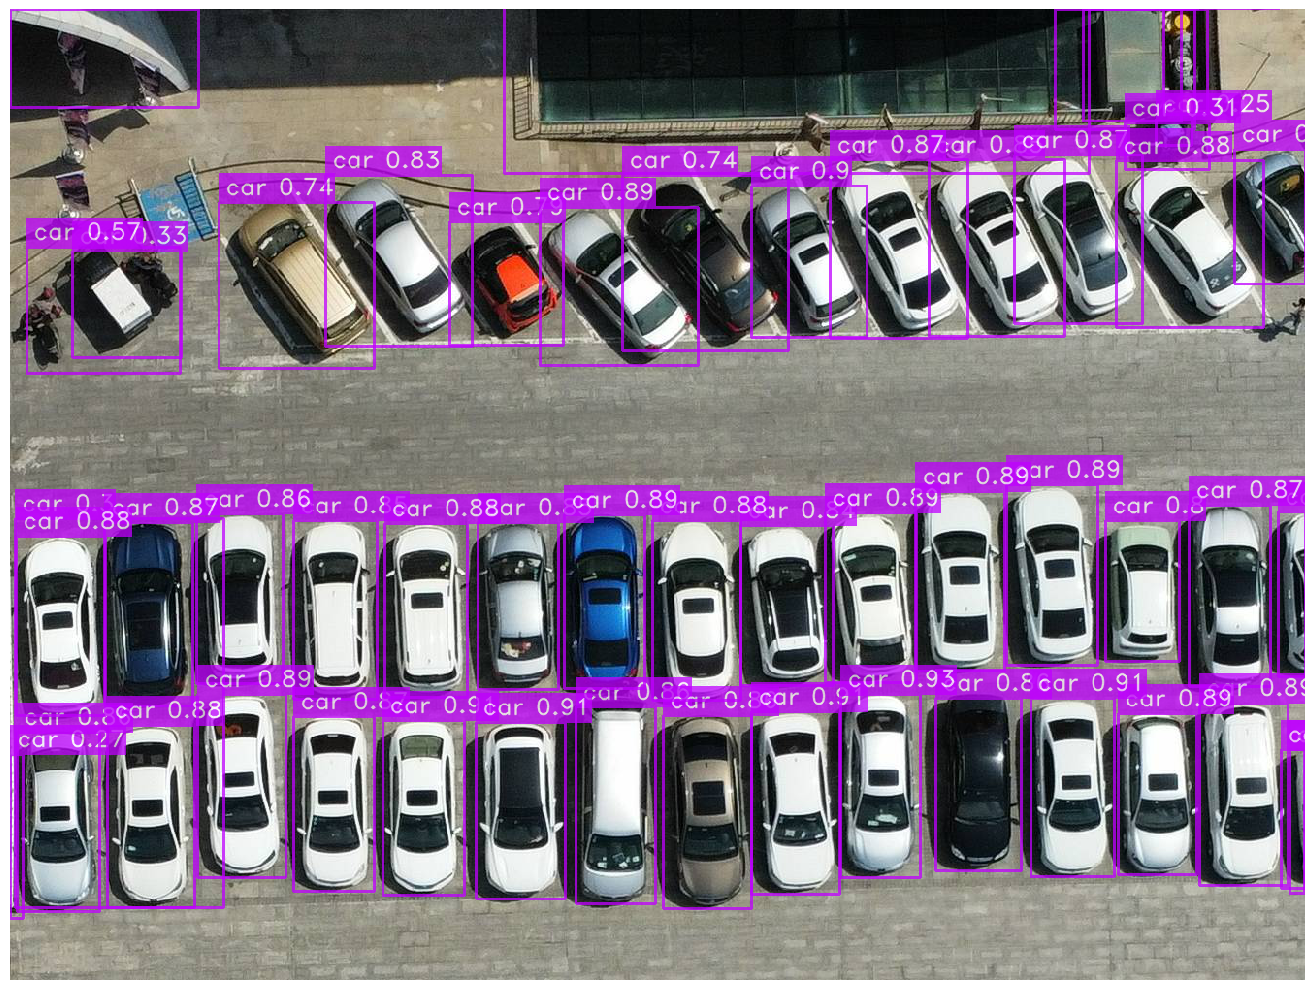

In [12]:
best_model.predict( "/kaggle/input/aerial-view-car-detection-for-yolov5/mydata/mydata/images/test/2 (43)_1650424073.jpg",  conf=0.25).show()

[2023-08-20 15:35:42] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


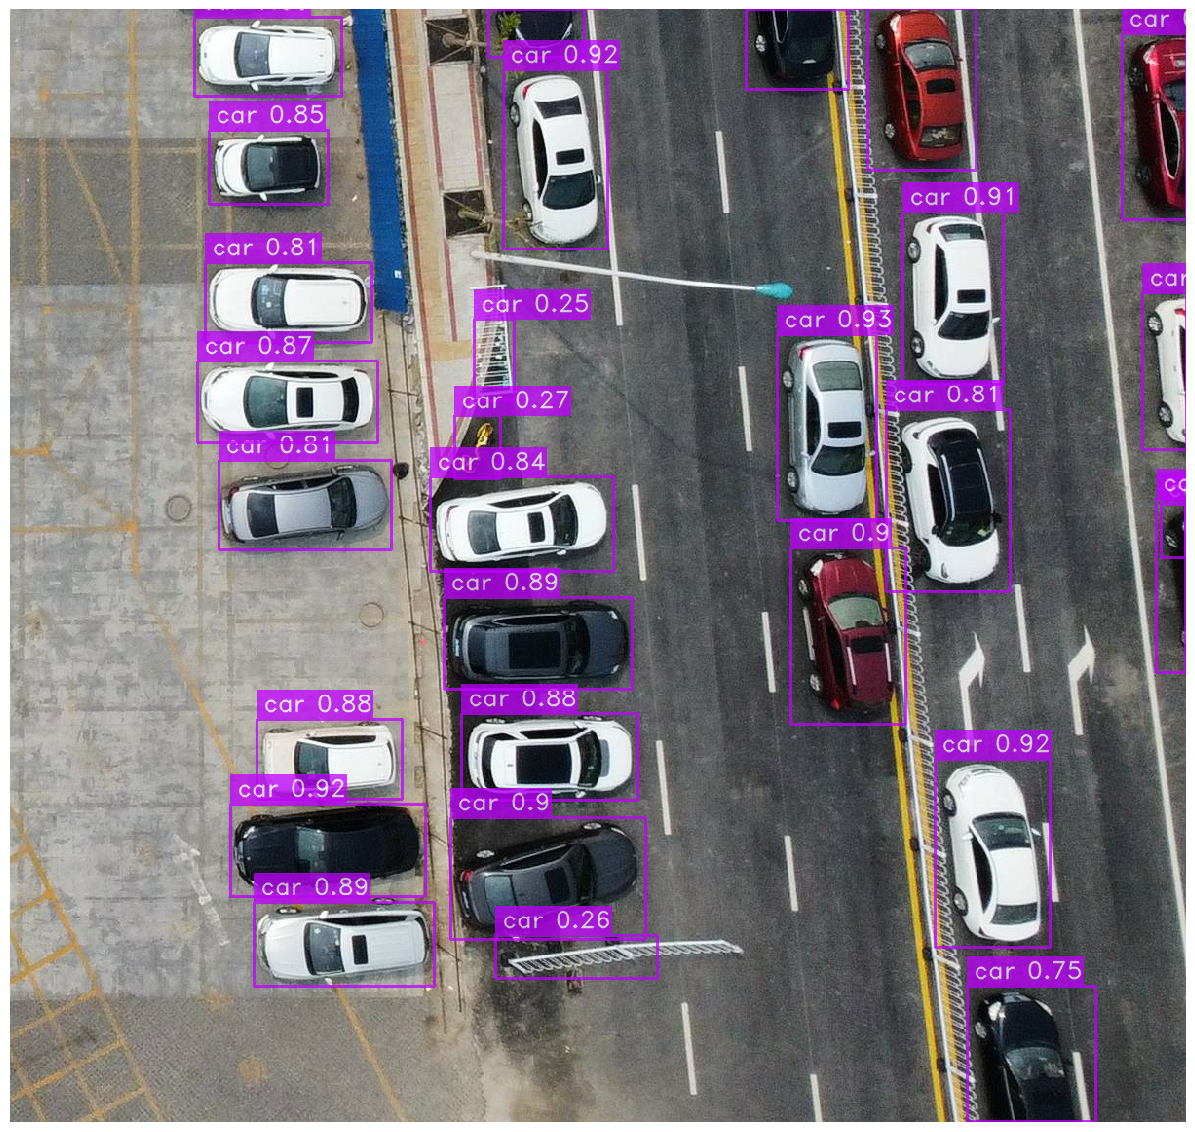

In [13]:
best_model.predict( "/kaggle/input/aerial-view-car-detection-for-yolov5/mydata/mydata/images/test/6 (39)_1650424380.jpg",  conf=0.25).show()

[2023-08-20 15:35:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


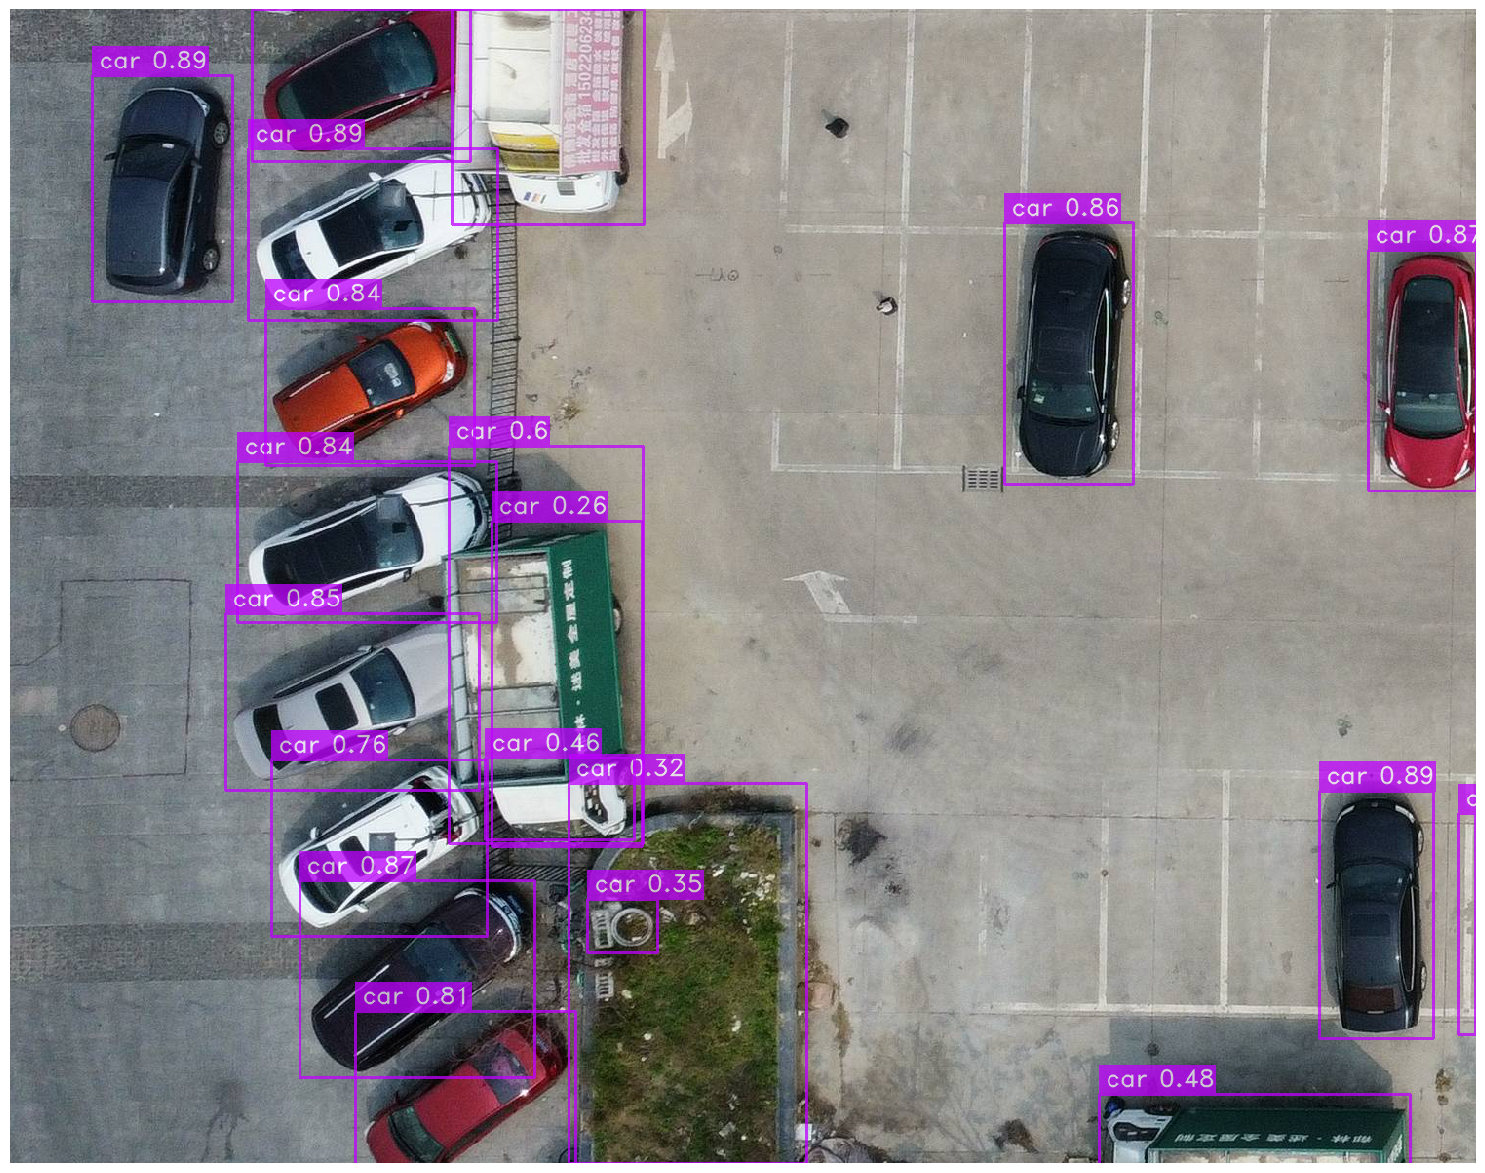

In [14]:
best_model.predict( "/kaggle/input/aerial-view-car-detection-for-yolov5/mydata/mydata/images/test/4 (32)_1650425271.jpg",  conf=0.25).show()